In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate
import astropy.units as u
import os
path=''#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings

#pip install lmfit, extinction, sfdmap, spectres

In [2]:
def get_mag_i(wave_spec,flux_spec,sigma_spec):
    filter_data = np.genfromtxt(path+'/SDSS filter curves.txt',delimiter='',dtype='str',unpack=True,skip_header=4)
    idx_i = np.where(filter_data[4]!='...')[0]
    i_filter = np.array([float(filter_data[4][idx_i][i]) for i in range(len(filter_data[4][idx_i]))])#sensitivity through 1.3 airmasses for a point source
    i_wave = np.array([float(filter_data[0][idx_i][i]) for i in range(len(filter_data[0][idx_i]))])
    t_i = interpolate.interp1d(i_wave,i_filter)
    idx_i = np.where((wave_spec>=i_wave[0])&(wave_spec<=i_wave[-1])&(sigma_spec!=np.inf))[0]
    if idx_i.size!=0:
        F_i = sum(flux_spec[idx_i]*t_i(wave_spec[idx_i]))/sum(t_i(wave_spec[idx_i]))
        F_i_Jy = F_i*10**-17*(3.34*10**4.0*7480.0**2.0)#convert to out units -> 10^-17 erg cm^-2 s^-1 A^-1 
        mag_i = -2.5*np.log10(F_i_Jy) + 8.9
        return mag_i
    else:
        print(1)
        return np.nan
    
# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

def get_spectra(spec_path):
    spec_list = os.listdir(spec_path)
    print('Number of spectra =', len(spec_list))
    num = 0
    sourceID = []
    flux_spec, sigma_spec, wave_spec = [], [], []
    RA, DEC, z = [],[],[] 

    start = time.time()
    for i in range(len(spec_list)):
        
            spec=fits.open(spec_path+spec_list[i],memmap=False) 
            RA.append(spec[2].data['PLUG_RA'][0])
            DEC.append(spec[2].data['PLUG_DEC'][0])
            z.append(spec[2].data['z'][0])
                        
            bad_pix = np.where(spec[1].data['ivar']==0)
            flux = spec[1].data['flux']
            flux[bad_pix] = np.nan
            flux_spec.append(flux)
            sigma_spec.append(np.sqrt(1/spec[1].data['ivar']))
            wave_vac = 10**spec[1].data['loglam']
            wave_spec.append(wave_vac)
                            
            num = num+1
            sourceID.append([spec[2].data['PLATE'][0], spec[2].data['MJD'][0], spec[2].data['FIBERID'][0]])
   
            spec.close()
            del spec
            
    end = time.time()
    print((end-start)/60,'min')

    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    z = np.array(z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    sourceID = np.array(sourceID,dtype=object)
    id_spec = [sourceID[:,0],sourceID[:,1],sourceID[:,2]]
    
    m_i = np.full(len(z),np.nan) 
    for i in range(len(z)):
        wave_max = max(wave_spec[i])
        m_i[i] = get_mag_i(wave_spec[i],flux_spec[i], sigma_spec[i])#some are below 7000A, other have ivar=0 in the vicinity of the i filter

    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec, m_i


def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec, mi = spec
    stack, sim_stack, corr_stack, ids = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack, sim_stack, corr_stack, ids


In [3]:
SFG_spec=get_spectra(path+'/SFG_sample/')# extract the file 

Number of spectra = 100
0.08433175881703694 min


In [4]:
#stack all available spectra
SFG_stack = get_stack(SFG_spec)

zbin: [(0.045071498, 0.20189102)]
Number of spectra to stack =  100
Spectra corrected for foreground extinction.
Number of divisions used for the correction: 30


In [5]:
#stack spectra in two redshift bins (i.e 0<z<0.1 and 0.1<z<0.2)
SFG_stacks = get_stack(SFG_spec, zbins=[[0.0,0.1],[0.1,0.2]])

zbin: [[0.0, 0.1], [0.1, 0.2]]
Number of spectra to stack =  70
Spectra corrected for foreground extinction.
Number of divisions used for the correction: 30
Number of spectra to stack =  29
Spectra corrected for foreground extinction.
Number of divisions used for the correction: 29


Text(0.5, 0, 'Rest-frame wavelength')

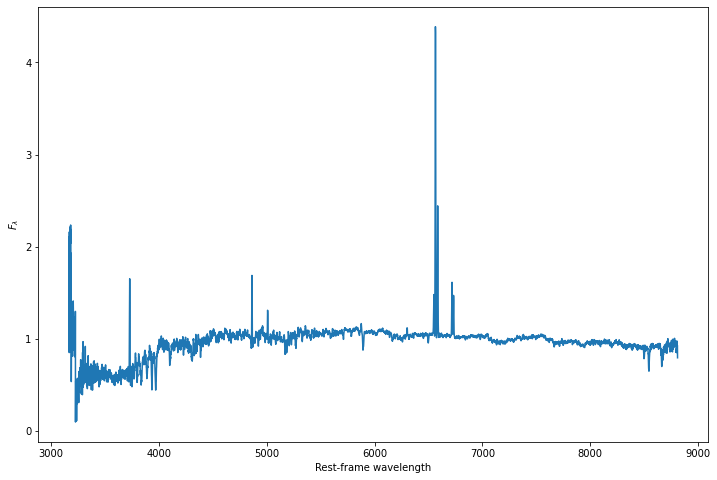

In [6]:
plt.figure(figsize=(12,8))
plt.plot(SFG_stack[2]['zbin=0']['wln'],SFG_stack[2]['zbin=0']['flux'])
plt.ylabel('$F_{\lambda}$')
plt.xlabel('Rest-frame wavelength')

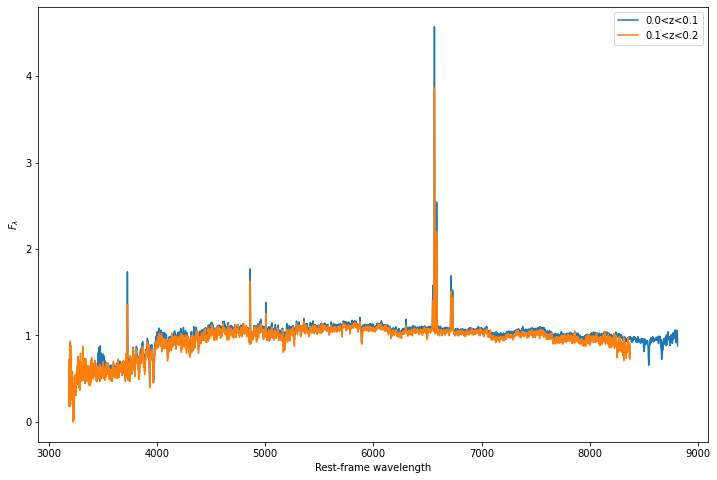

In [7]:
plt.figure(figsize=(12,8))
plt.plot(SFG_stacks[2]['zbin=0']['wln'],SFG_stacks[2]['zbin=0']['flux'], label='0.0<z<0.1')
plt.plot(SFG_stacks[2]['zbin=1']['wln'],SFG_stacks[2]['zbin=1']['flux'], label='0.1<z<0.2', alpha=0.5)
plt.ylabel('$F_{\lambda}$')
plt.xlabel('Rest-frame wavelength')
plt.legend()